In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

def make_heat_map(file_name):

    name = file_name[:-4].upper()
    data = pd.read_csv(file_name, header=None)
    data = data.dropna()

    kde = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data)
    samples = kde.sample(n_samples = 10000, random_state = 42)

    data = pd.DataFrame(data, columns=['Exit Velocity','Launch Angle'])
    samples = pd.DataFrame(samples, columns=['Exit Velocity','Launch Angle'])
    sns.set_theme(style="white")

    clip_min_x = min(samples['Exit Velocity']) - 10
    clip_max_x = max(samples['Exit Velocity']) + 10
    clip_min_y = min(samples['Launch Angle']) - 10
    clip_max_y = max(samples['Launch Angle']) + 10

    g = sns.JointGrid(data=samples, x='Exit Velocity', y='Launch Angle', space=0)
    g.plot_joint(sns.kdeplot,
             fill=True, cut = 20, clip = ((clip_min_x,clip_max_x),(clip_min_y,clip_max_y)),
             thresh=0, levels=100, cmap="rocket")
    g.plot_marginals(sns.histplot, color="#03051A", alpha=1, bins=25)
    if (name[-1] == 'S'):
        g.fig.suptitle(name + "' HEAT MAP\n", y = 1.02)
    else: 
        g.fig.suptitle(name + "'S HEAT MAP\n", y = 1.02)

def similarity_score(file1, file2):
    data1 = pd.read_csv(file1, header=None)
    data1 = data1.dropna()
    kde1 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data1)

    data2 = pd.read_csv(file2, header=None)
    data2 = data2.dropna()
    kde2 = KernelDensity(bandwidth = 1.0, kernel = 'gaussian').fit(data2)

    min_exit_velocity = int(min(min(data1[0]),min(data2[0])) - 10)
    max_exit_velocity = int(max(max(data1[0]),max(data2[0])) + 10)
    min_launch_angle = int(min(min(data1[1]),min(data2[1])) - 10)
    max_launch_angle = int(max(max(data1[1]),max(data2[1])) + 10)

    score_sum = 0
    x_range = range(min_exit_velocity,max_exit_velocity)
    y_range = range(min_launch_angle,max_launch_angle)
    lattice_size = len(x_range) * len(y_range)
    for x in x_range:
        for y in y_range:
            score_sum += abs(kde1.score(np.array([x,y]).reshape(1,-1)) - kde2.score(np.array([x,y]).reshape(1,-1)))

    return np.ceil((score_sum / lattice_size) * 100) / 100
        


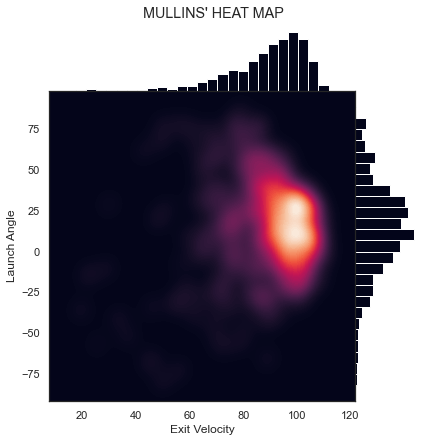

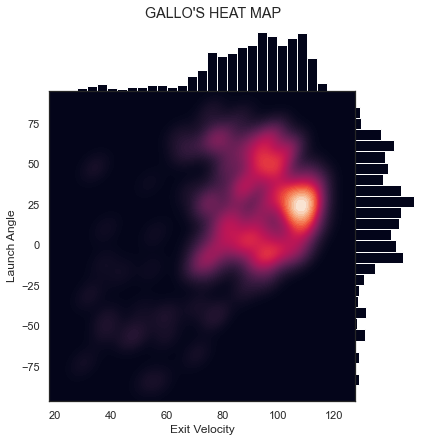

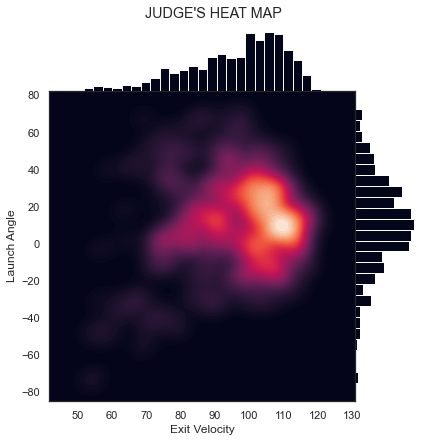

In [78]:
make_heat_map('mullins.csv')
make_heat_map('gallo.csv')
make_heat_map('judge.csv')

In [79]:
print('Mullins v Gallo: ' + str(similarity_score('mullins.csv','gallo.csv')))
print('Mullins v Judge: ' + str(similarity_score('mullins.csv','judge.csv')))
print('Gallo v Judge: ' + str(similarity_score('gallo.csv','judge.csv')))
print('Judge v Gallo: ' + str(similarity_score('judge.csv','gallo.csv')))
print('Mullins v Mullins: ' + str(similarity_score('mullins.csv','mullins.csv')))

Mullins v Gallo: 103.14
Mullins v Judge: 214.61
Gallo v Judge: 128.32
Judge v Gallo: 128.32
Mullins v Mullins: 0.0
